In [1]:
import dp4gp_datasets
import dp4gp
import random
import numpy as np
import GPy
import dp4gp_histogram
import pandas as pd
from sklearn.metrics import mean_squared_error
import sys
import scipy
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline


def get_citibike_data():
    allcb = dp4gp_datasets.load_citibike(station=None)
    subcb = allcb[allcb['usertype']=='Subscriber']

    cb = subcb.ix[random.sample(subcb.index, 5000)]
    inputs = np.c_[cb['start station latitude'],cb['end station latitude'],cb['start station longitude'],cb['end station longitude']]
    ys = cb['tripduration'].values
    
    return inputs, ys
    

warning in stationary: failed to import cython module: falling back to numpy


In [2]:
inputs, ys = get_citibike_data()

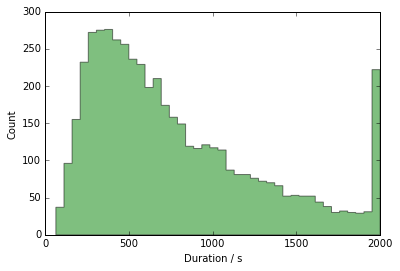

In [3]:
ys[ys>2000]=2000
plt.hist(ys,40,histtype='stepfilled',alpha=0.5,color='green');
plt.xlabel('Duration / s')
plt.ylabel('Count')
plt.savefig('citibike_hist.pdf')

In [4]:
np.min(inputs,0)

array([ 40.67890679,  40.67890679, -74.01713445, -74.01713445])

In [6]:
def get_hist_prediction(training_inputs, training_ys, test_inputs, sens, eps, delta,noise,modvar,kernval,kern_ls,steps):
    Xtest, free_inputs, step = dp4gp.compute_Xtest(training_inputs,steps=steps)
    print step
    print Xtest.shape
    dpgp = dp4gp_histogram.DPGP_histogram(sens,eps,delta)
    bincounts, bintotals, binaverages, sens_per_bin, bin_sigma, dp_binaverages = dpgp.prepare_model(Xtest,training_inputs,step,training_ys,lengthscale=kern_ls, aggregation='median')
    preds, cov = dpgp.draw_prediction_samples(test_inputs)
    return preds, cov, dpgp, bincounts


In [7]:
vs = []
inputs, ys = get_citibike_data()
ys[ys>2000] = 2000
ys[ys<0]= 0
sens = 2000.0

ys_mean = np.mean(ys)
ys_std = np.std(ys)
ys = ys - ys_mean
ys = ys / ys_std
sens = sens / ys_std

training_inputs = inputs[0:-100,:]
training_ys = ys[0:-100][:,None]
test_inputs = inputs[-100:,:]
test_ys = ys[-100:][:,None]

test_inputs = inputs[-100:,:]
test_ys = ys[-100:][:,None]

kernvar = 10.0
kern_ls = np.array([0.01,0.01,0.01,0.01])*1.0
eps = 1.0
steps = 1

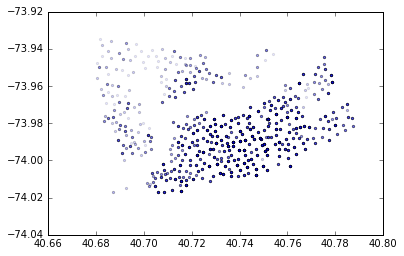

In [8]:
plt.scatter(training_inputs[:,0],training_inputs[:,2],marker='.',alpha=0.1)

In [9]:
preds, cov,dpgp,counts = get_hist_prediction(training_inputs,training_ys,test_inputs,sens,eps,0.01,10.0,1.0, kernvar, kern_ls, steps)
dpgp.draw_prediction_samples(test_inputs[0:1,0:]+0.0001)

[ 0.12823952  0.12996228  0.09867774  0.10469202]
(1, 4)


NotImplementedError: 

In [ ]:
np.std(training_ys)*ys_std

In [ ]:
steps = 10
trainX = np.array([[1,2,3,4,5,6]]).T
trainY = np.array([1,2,3,4,5,6])
testX = np.array([[4,2]]).T
testY = np.array([4,2])
preds, cov, _, _ = get_hist_prediction(trainX,trainY,testX,0.0,1.0,0.01,10.0,1.0, 0,0, steps)
print preds
RMSE = np.sqrt(np.mean((testY-preds)**2))
print RMSE

In [ ]:
vs = []
for its in range(30):
    inputs, ys = get_citibike_data()
    ys[ys>2000] = 2000
    ys[ys<0]= 0

    ys_mean = np.mean(ys)
    ys_std = np.std(ys)
    ys = ys - ys_mean
    ys = ys / ys_std

    training_inputs = inputs[0:-100,:]
    training_ys = ys[0:-100][:,None]
    test_inputs = inputs[-100:,:]
    test_ys = ys[-100:][:,None]

    test_inputs = inputs[-100:,:]
    test_ys = ys[-100:][:,None]

    results = {}

    for steps in [3]: #3,6,10]:
        results[steps] = {} 
        for eps in [0.2,0.5,1.0,1000]:
            print "Steps = %d, eps = %0.1f" % (steps,eps)
            if eps>100:
                sens = 0
            else:
                sens = 2000
            kernvar = 10.0
            kern_ls = np.array([0.01,0.01,0.01,0.01])*1.0


            sens = sens / ys_std

            preds, cov, _, _ = get_hist_prediction(training_inputs,training_ys,test_inputs,sens,eps,0.01,10.0,1.0, kernvar, kern_ls, steps)
            RMSE = np.sqrt(np.mean((test_ys-preds)**2))
            results[steps][eps] = {'preds':preds, 'cov':cov, 'RMSE':RMSE, 'ys_std':ys_std}
    v = []
    for j in np.sort(results.keys()):
        for k in np.sort(results[j].keys())[::-1]:
            #print str(j)+","+str(k)+":",
            #print str(results[j][k]['RMSE']*results[j][k]['ys_std'])+",",
            v.append(results[j][k]['RMSE']*results[j][k]['ys_std']) 
    vs.append(v)

In [ ]:
for j in np.sort(results.keys()):
    for k in np.sort(results[j].keys())[::-1]:
        print str(j)+","+str(k)+":",
        print str(results[j][k]['RMSE']*results[j][k]['ys_std'])+",",


In [ ]:
ys_std

In [ ]:
np.mean(vs,0)

In [ ]:
np.std(vs,0)/np.sqrt(30)

In [ ]:
for j in np.sort(results.keys()):
    for k in np.sort(results[j].keys())[::-1]:
        print str(results[j][k]['RMSE']*results[j][k]['ys_std'])+",",
